# Wasserstein GAN
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.0.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
filenames = {
    "herwig": "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

train_features = ["tau21j2"] # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 512 # Uses about 3 GB of VRAM
EPOCHS = 1000
LEARNING_RATE = 0.00005
N_CRITIC = 5

In [5]:
df = load_data("herwig")

# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
X_train, X_test = train_test_split(df[train_features], test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()

Dataset consists of 1464 batches of 512 samples each, total 749568 samples
Testset consists of 488 batches of 512 samples each, total 249856 samples


39

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features)))
    assert model.output_shape == (None, len(train_features))

    return model

In [9]:
generator = make_generator_model()

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [11]:
discriminator = make_discriminator_model()

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [14]:
def discriminator_loss(real_output, fake_output):
    return tf.math.subtract(fake_output, real_output)

In [15]:
def generator_loss(fake_output):
    return tf.math.negative(fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE, clipnorm = 1.0)

In [17]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [18]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [19]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [20]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [21]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    disc_loss = discriminator_loss(real_output, fake_output)

    return disc_loss

In [22]:
def graph_gan(generator):
    fakedata = np.array(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.title("N-subjettiness ratio")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$\\tau_{21J_2}$")
    plt.hist(np.array(X_train)[:,0], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [23]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [24]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [25]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [26]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = ((epoch + 1) % 100 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(tf.math.reduce_mean(train_step_generator(image_batch)))
      for n in range(n_critic):
        train_disc_loss += K_eval(tf.math.reduce_mean(train_step_discriminator(image_batch)))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(tf.math.reduce_mean(evaluate_generator()))
      test_disc_loss += K_eval(tf.math.reduce_mean(evaluate_discriminator(test_batch)))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_genloss()
      graph_discloss()

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING:tensorflow:Layer dense_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 10%|▉         | 99/1000 [27:01<4:05:00, 16.32s/it]
Epoch 100:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 100:


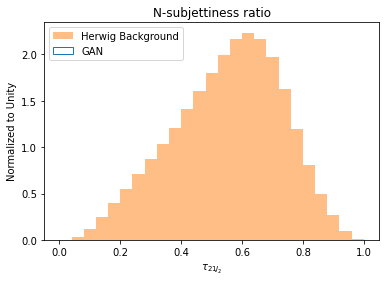

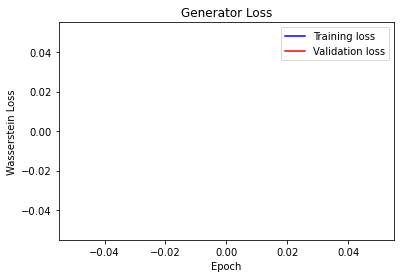

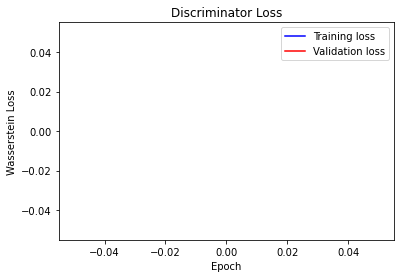

 20%|█▉        | 199/1000 [54:10<3:39:29, 16.44s/it]
Epoch 200:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 200:


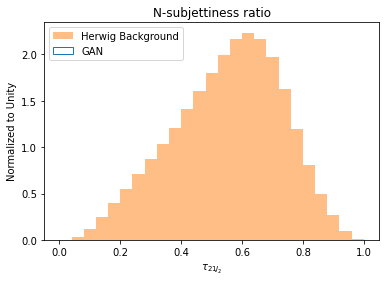

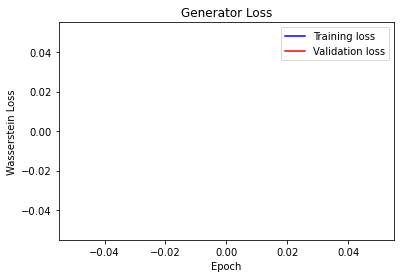

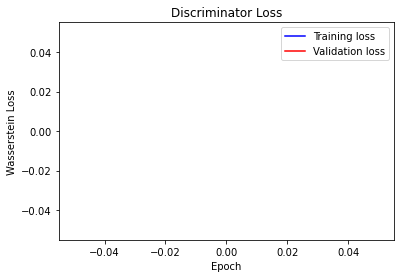

 30%|██▉       | 299/1000 [1:21:11<3:02:38, 15.63s/it]
Epoch 300:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 300:


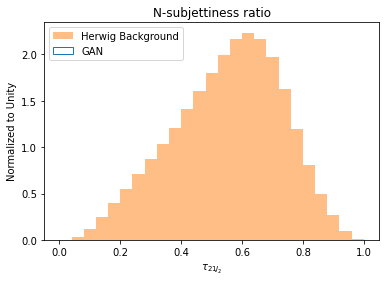

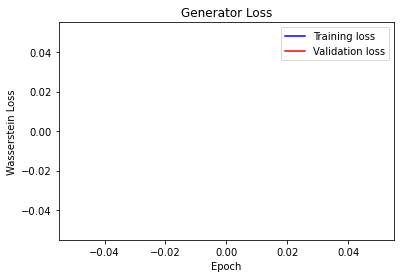

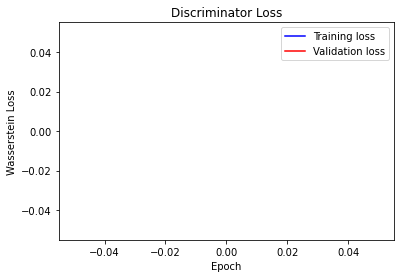

 40%|███▉      | 399/1000 [1:47:32<2:37:53, 15.76s/it]
Epoch 400:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 400:


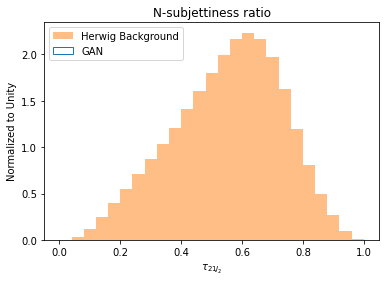

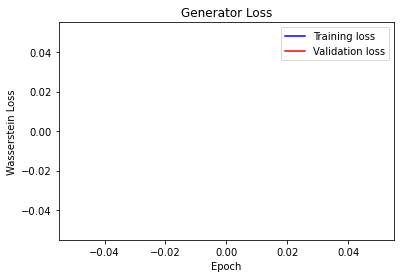

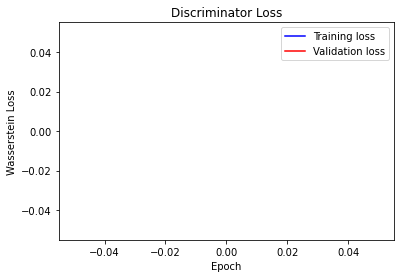

 50%|████▉     | 499/1000 [2:13:52<2:12:05, 15.82s/it]
Epoch 500:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 500:


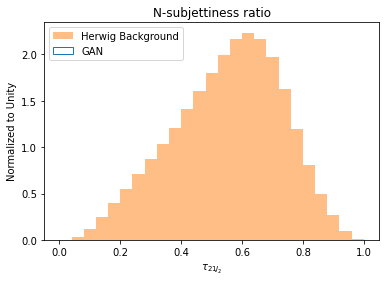

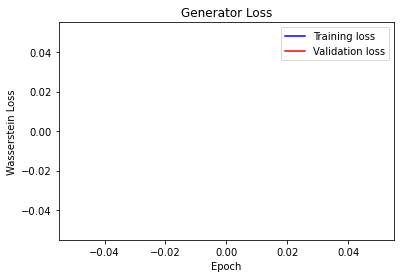

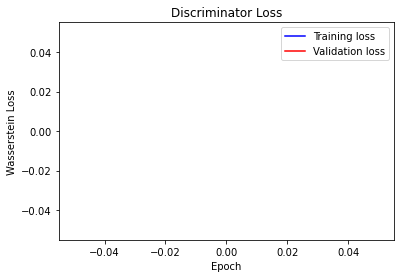

 60%|█████▉    | 599/1000 [2:40:07<1:46:19, 15.91s/it]
Epoch 600:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 600:


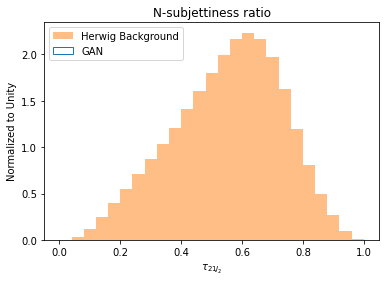

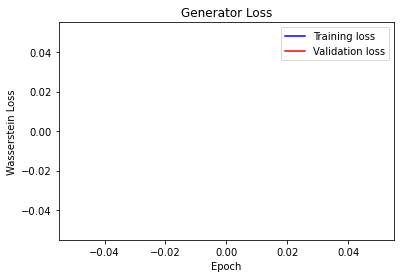

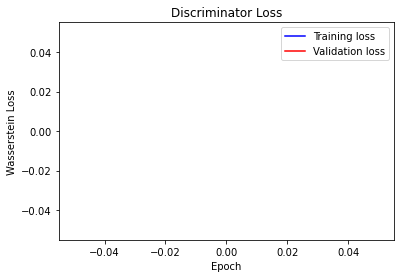

 70%|██████▉   | 699/1000 [3:06:36<1:20:18, 16.01s/it]
Epoch 700:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 700:


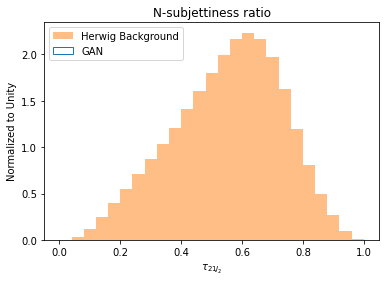

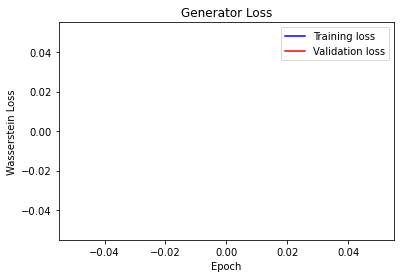

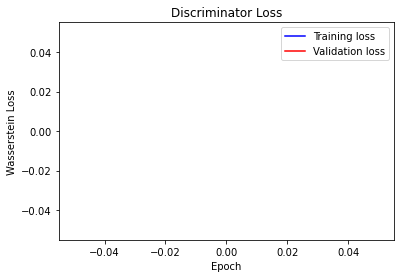

 80%|███████▉  | 799/1000 [3:32:54<52:22, 15.63s/it]
Epoch 800:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 800:


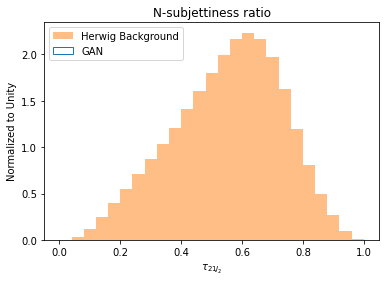

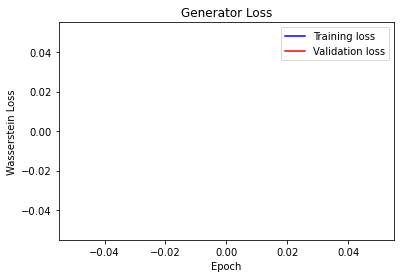

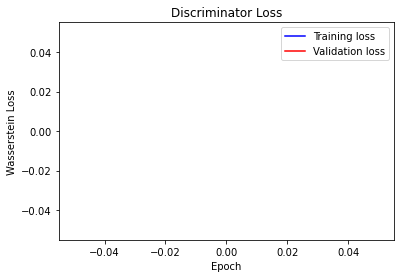

 90%|████████▉ | 899/1000 [3:59:09<26:20, 15.65s/it]
Epoch 900:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 900:


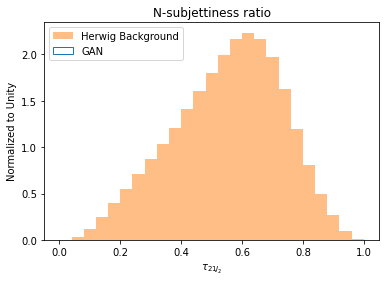

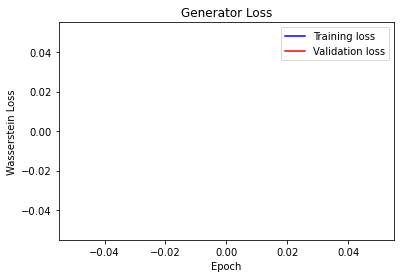

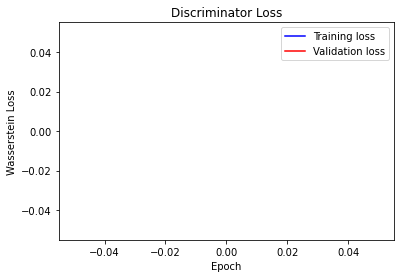

100%|█████████▉| 999/1000 [4:25:52<00:15, 15.98s/it]
Epoch 1000:

Generator training loss: nan
Discriminator training loss: nan

Generator validation loss: nan
Discriminator validation loss: nan

Epoch 1000:


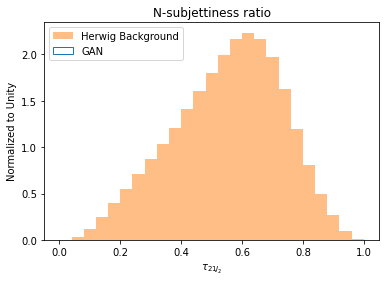

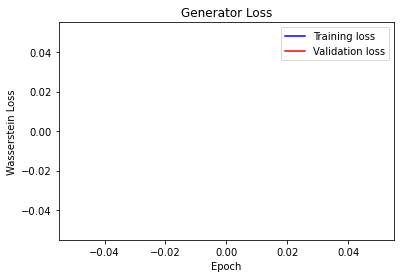

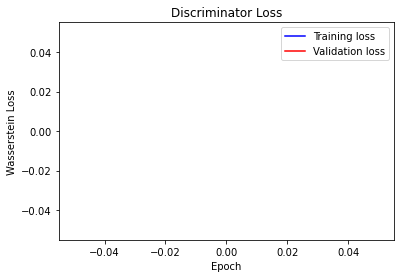

100%|██████████| 1000/1000 [4:26:09<00:00, 15.97s/it]


In [27]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)